[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FixelAlgorithmsTeam/FixelCourses/blob/master/AIProgram/2024_02/0087DeepLearningConv2DFashionMNIST.ipynb)

The data can be downloaded from:
https://www.kaggle.com/datasets/dschettler8845/brats-2021-task1/data

In [222]:
# Import Packages

# General Tools
import numpy as np
import scipy as sp
import pandas as pd

# Machine Learning
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

# Deep Learning
import torch
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter
import torchinfo
from torchmetrics.classification import MulticlassAccuracy
import torchvision

# Miscellaneous
import math
import os
from platform import python_version
import random
import time

# Typing
from typing import Callable, Dict, Generator, List, Optional, Self, Set, Tuple, Union

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Jupyter
from IPython import get_ipython
from IPython.display import HTML, Image
from IPython.display import display
from ipywidgets import Dropdown, FloatSlider, interact, IntSlider, Layout, SelectionSlider
from ipywidgets import interact

import pytest
import nibabel as nib
import os
from nibabel.testing import data_path
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from skimage.util import montage 
from skimage.transform import rotate



## Notations

* <font color='red'>(**?**)</font> Question to answer interactively.
* <font color='blue'>(**!**)</font> Simple task to add code for the notebook.
* <font color='green'>(**@**)</font> Optional / Extra self practice.
* <font color='brown'>(**#**)</font> Note / Useful resource / Food for thought.

Code Notations:

```python
someVar    = 2; #<! Notation for a variable
vVector    = np.random.rand(4) #<! Notation for 1D array
mMatrix    = np.random.rand(4, 3) #<! Notation for 2D array
tTensor    = np.random.rand(4, 3, 2, 3) #<! Notation for nD array (Tensor)
tuTuple    = (1, 2, 3) #<! Notation for a tuple
lList      = [1, 2, 3] #<! Notation for a list
dDict      = {1: 3, 2: 2, 3: 1} #<! Notation for a dictionary
oObj       = MyClass() #<! Notation for an object
dfData     = pd.DataFrame() #<! Notation for a data frame
dsData     = pd.Series() #<! Notation for a series
hObj       = plt.Axes() #<! Notation for an object / handler / function handler
```

### Code Exercise

 - Single line fill

 ```python
 vallToFill = ???
 ```

 - Multi Line to Fill (At least one)

 ```python
 # You need to start writing
 ????
 ```

 - Section to Fill

```python
#===========================Fill This===========================#
# 1. Explanation about what to do.
# !! Remarks to follow / take under consideration.
mX = ???

???
#===============================================================#
```

In [223]:
# Configuration
# %matplotlib inline

seedNum = 512
np.random.seed(seedNum)
random.seed(seedNum)

# Matplotlib default color palette
lMatPltLibclr = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
# sns.set_theme() #>! Apply SeaBorn theme

runInGoogleColab = 'google.colab' in str(get_ipython())

# Improve performance by benchmarking
torch.backends.cudnn.benchmark = True

# Reproducibility
# torch.manual_seed(seedNum)
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark     = False


In [224]:
# Constants


IMG_SIZE = (240,240,155)

TENSOR_BOARD_BASE   = 'TB'


In [225]:
# Download Auxiliary Modules for Google Colab
if runInGoogleColab:
    !wget https://raw.githubusercontent.com/FixelAlgorithmsTeam/FixelCourses/master/AIProgram/2024_02/DataManipulation.py
    !wget https://raw.githubusercontent.com/FixelAlgorithmsTeam/FixelCourses/master/AIProgram/2024_02/DataVisualization.py
    !wget https://raw.githubusercontent.com/FixelAlgorithmsTeam/FixelCourses/master/AIProgram/2024_02/DeepLearningPyTorch.py

In [226]:
# Courses Packages

from DataVisualization import PlotLabelsHistogram, PlotMnistImages
from DeepLearningPyTorch import TrainModel


In [227]:
if torch.cuda.is_available(): 
 dev = "cuda:0" 
else: 
 dev = "cpu" 
 device = torch.device(dev)


## Brain Tumor Image Classification using DL




In [228]:
# Parameters

# Data
numSamplesTrain = 0 #TBD after we know how many samples we have
numSamplesTest  = 0 #TBD after we know how many samples we have
trainTestPercentage = 0.2
# Model
dropP = 0.2 #<! Dropout Layer

# Training
batchSize   = 10
numWork     = 2 #<! Number of workers
nEpochs     = 30

# Visualization
numImg = 3

# samples root directory
root_dir = '/Users/ronenrayten/Downloads/archive2021/'

# image types
img_types = ['t1','t1ce','t2','flair','seg']

#number of pixels in an image
p_image_size = IMG_SIZE[0]*IMG_SIZE[1]*IMG_SIZE[2]

## Generate / Load Data

Load the [Brain Tumor Segmentation](https://www.kaggle.com/datasets/andrewmvd/brain-tumor-segmentation-in-mri-brats-2015/data).  

* the 2020 directory was rearanged to comply with 2018 and 2019 directories. I have added to sub directories under "MICCAI_BraTS2020_TrainingData" directory, HGG and LGG to include all the relevent samples.
* the file /Users/ronenrayten/Downloads/archive/MICCAI_BraTS2020_TrainingData/HGG/BraTS20_Training_355/W39_1998.09.19_Segm.nii was not in the right format. Changed to W39_1998.09.19_seg.nii


In [256]:
# Get one sample that consists of 4 images (t1,t1ce,t2,flair) and a segmentation image (seg)

def get_sample(sample_path):
    file_extension = ['_t1.','_t1ce.','_t2.','_flair.','_seg.']
    title = ['t1','t1ce','t2','flair','seg']
    img = np.zeros(p_image_size*5)
    img = img.reshape(5,*IMG_SIZE)


    files = os.listdir(sample_path)
    for ext in file_extension:
     for file in files:
       if ext in file and ext == '_t1.': 
          im = nib.load(sample_path+'/'+file).get_fdata()
          img[0] = im
       if ext in file and ext == '_t1ce.': 
          im = nib.load(sample_path+'/'+file).get_fdata()
          img[1] = im
       if ext in file and ext == '_t2.': 
          im = nib.load(sample_path+'/'+file).get_fdata()
          img[2] = im
       if ext in file and ext == '_flair.': 
          im = nib.load(sample_path+'/'+file).get_fdata()
          img[3] = im
       if ext in file and ext == '_seg.': 
          im = nib.load(sample_path+'/'+file).get_fdata()
          img[4] = im
          
    return img
  
     
# get the list of file names (all samples) 
# the returned value is formed as follows:
# number_of_samples x number of images per sample (5)
# the images are ordered that as follows: [0] t1, [1] t1ce, [2] t2, [3] flair, [4] seg
def get_file_names_by_type(root_path):
   files = os.listdir(root_path)
   
   file_list = []
   
   for file_name in files:
     if os.path.isdir(root_path +file_name):
      all_samples_dirs = os.listdir(root_path + file_name +'/')
      for nii_dir in all_samples_dirs:
        if os.path.isdir(root_path + file_name + '/'+nii_dir):
           nii_files = os.listdir(root_path +'/'+ file_name + '/'+nii_dir)
           
           local_dir = root_path + file_name + '/'+nii_dir+'/'
           sample_files=['','','','','']
           for file in nii_files:
            if '_t1.' in file: 
               sample_files[0] = local_dir+file
            elif '_t1ce.' in file: 
               sample_files[1] = local_dir+file
            elif '_t2.' in file: 
               sample_files[2] = local_dir+file
            elif '_flair.' in file: 
               sample_files[3] = local_dir+file
            elif '_seg.' in file: 
               sample_files[4] = local_dir+file
            else:
               print (file)
           file_list.append(sample_files)

   return np.array(file_list)



# print a specific sample. The sample consists of 5 images.
def print_sample(sample_path):
  
  title = ['t1','t1ce','t2','flair','seg']
  img = np.zeros(p_image_size*5)
  img = img.reshape(5,*IMG_SIZE)
  
  img = get_sample(sample_path)

  fig, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(1,5, figsize = (12, 6))
  ax_all = (ax1,ax2,ax3,ax4,ax5)

  i=0
  for ax in ax_all:
    ax.imshow(img[i][:,:,75])
    ax.set_title(title[i])
    i+=1

#print an image file 
def show_img(img):
   fig, ax = plt.subplots(1,1, figsize = (12, 6))
   ax.imshow(img)
   

 
def calculate_mean_std_per_channel(image_files):
    channel_means = torch.zeros(len(image_files),4)
    channel_stds = torch.zeros(len(image_files),4)
    
    channel_means = channel_means.to(device)
    channel_stds = channel_stds.to(device)

    for i in range(len(image_files)):
       print(f'working on sample:{i} out of {len(image_files)}')
       for j in range(4):
        # Load image data
        image_data = torch.from_numpy(nib.load(image_files[i][j]).get_fdata())

        # Compute mean and std per channel
        channel_means[i,j] = torch.mean(image_data)
        channel_stds[i,j] = torch.std(image_data)

    # Aggregate results across all images
    mean_per_channel = torch.mean(channel_means, axis=0)
    std_per_channel = torch.mean(channel_stds, axis=0)

    return mean_per_channel, std_per_channel

In [246]:

# Load the segmentation mask
seg_nii_path = '/Users/ronenrayten/Downloads/archive2021/BraTS2021_Training_Data/BraTS2021_01666/BraTS2021_01666_seg.nii.gz'
seg_nii = nib.load(seg_nii_path)
seg_data = seg_nii.get_fdata()

seg_nii = nib.load(seg_nii_path)
seg_data = seg_nii.get_fdata()

# Define label values
NCR_label = 1
ED_label = 2
ET_label = 4

# Create masks for each label
NCR_mask = (seg_data == NCR_label).astype(np.uint8)
ED_mask = (seg_data == ED_label).astype(np.uint8)
ET_mask = (seg_data == ET_label).astype(np.uint8)

# Combine masks to get segmented labels
segmented_labels = NCR_mask * NCR_label + ED_mask * ED_label + ET_mask * ET_label

# Set 0 for everything else
segmented_labels[segmented_labels == 0] = 0
np.unique(seg_data)

array([0., 1., 2.])

tensor(224.2659, dtype=torch.float64)


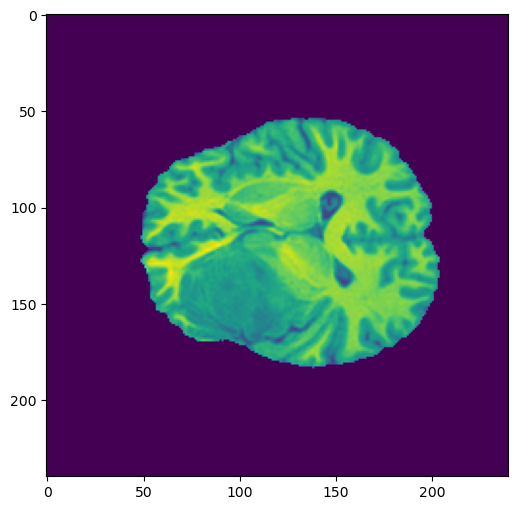

In [245]:
#Print test image

seg_nii_path = '/Users/ronenrayten/Downloads/archive2021/BraTS2021_Training_Data/BraTS2021_01666/BraTS2021_01666_t1.nii.gz'
seg_nii = nib.load(seg_nii_path)
seg_data = seg_nii.get_fdata()
s = seg_data.flatten()
image_data = torch.from_numpy(seg_data)
print(torch.mean(image_data))
b = s.reshape(240,240,155)
show_img(b[:,:,75])

get the list of files

In [262]:
file_list = get_file_names_by_type(root_dir)  
#x,y = calculate_mean_std_per_channel(file_list) 


In [263]:
numSamplesTest = np.int32(np.round(len(file_list) * trainTestPercentage))
numSamplesTrain = len(file_list) - numSamplesTest

print("Number of Train samples:",numSamplesTrain)
print("Number of Test samples:",numSamplesTest)

Number of Train samples: 1001
Number of Test samples: 250


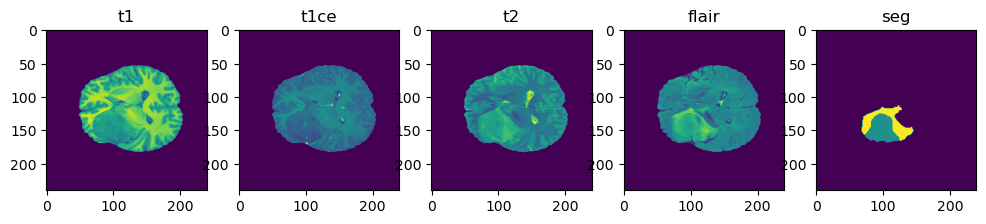

In [264]:
# test a sample printing
print_sample('/Users/ronenrayten/Downloads/archive2021/BraTS2021_Training_Data/BraTS2021_01666')

## Define the dataset and Loader

The dataset takes as parameters:
* type_of_bc - the type of cancer HGG/LGG
* image return a concatination of the 4 images - t1,t1ce,t2,flair - actualy creating a 4 channel image


In [273]:

    
class ImageDatasetFromMem(Dataset):
    def __init__(self, mX, vY, transform=None, target_transform=None):
        
        self.images = mX
        self.labels = vY
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return self.images.shape[0]

    def __getitem__(self, idx):
        
        image = np.zeros(4*p_image_size)
        image = self.images[idx]
        image = image.reshape(4,*IMG_SIZE)
          
        label = np.zeros(p_image_size)
        label = self.labels[idx]
        label = label.reshape(1,*IMG_SIZE)
        
        
        
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label
    

###################################################################
#
# The format of the batch returned:
# Image: batch_size x number of images (4) x image_size (240x240x155)
# Label: batch_size x number of images (1) x image_size (240x240x155)
###################################################################

class ImageDatasetFromDisk(Dataset):
    def __init__(self, mX, vY, transform=None, target_transform=None):
        
        self.images = mX
        self.labels = vY
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return self.images.shape[0]

    def __getitem__(self, idx):
        
        image = np.zeros(p_image_size*4)
        image = image.reshape(4,*IMG_SIZE)
        for i in range(4):
            image[i] = nib.load(self.images[idx][i]).get_fdata()
        
        label = np.zeros(p_image_size)
        label = label.reshape(1,*IMG_SIZE)
        label[0] = nib.load(self.labels[idx]).get_fdata()
        
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

## Pre Process Data

This section normalizes the data to have zero mean and unit variance per **channel**.  
It is required to calculate:

 * The average pixel value per channel.
 * The standard deviation per channel.

In [266]:
# Calculate the Standardization Parameters

#===========================Fill This===========================#
# 1. Calculate the mean per channel.
# 2. Calculate the standard deviation per channel.

#file_list = get_file_names_by_type(root_dir,'HGG')
#µ  = [np.mean(mX[:,:p_image_size]),np.mean(mX[:,p_image_size:p_image_size*2]),np.mean(mX[:,p_image_size*2:p_image_size*3]),np.mean(mX[:,p_image_size*3:p_image_size*4])]
#σ  = [np.std(mX[:,:p_image_size]),np.std(mX[:,p_image_size:p_image_size*2]),np.std(mX[:,p_image_size*2:p_image_size*3]),np.std(mX[:,p_image_size*3:p_image_size*4])]

#===============================================================#
µ = [150.4406, 251.8686, 249.5104, 102.3567]
σ = [348.5170, 596.2430, 648.1568, 244.0763]
print('µ =', µ)
print('σ =', σ)

µ = [150.4406, 251.8686, 249.5104, 102.3567]
σ = [348.517, 596.243, 648.1568, 244.0763]


Test the loader

* <font color='brown'>(**#**)</font> The images are grayscale with size `240x240`.

### Plot the Data

In [215]:
# Histogram of Labels - TBD

#hA = PlotLabelsHistogram(vY, lClass = L_CLASSES_FASHION_MNIST)
#plt.show()

## Train & Test Split

In [295]:
# Train Test Split - TBD

#numClass = len(np.unique(vY))

#===========================Fill This===========================#
# 1. Split the data into train and test (Validation) data sets (NumPy arrays).
# 2. Use stratified split.
# !! The output should be: `mXTrain`, `mXTest`, `vYTrain`, `vYTest`.
mX = file_list[:,:4]
vY = file_list[:,4]
mXTrain, mXTest, vYTrain, vYTest = train_test_split(mX, vY, test_size = numSamplesTest, train_size = numSamplesTrain, shuffle = True)
#===============================================================#

print(f'The training features data shape: {mXTrain.shape}')
print(f'The training labels data shape: {vYTrain.shape}')
print(f'The test features data shape: {mXTest.shape}')
print(f'The test labels data shape: {vYTest.shape}')
#print(f'The unique values of the labels: {np.unique(vY)}')


The training features data shape: (1001, 4)
The training labels data shape: (1001,)
The test features data shape: (250, 4)
The test labels data shape: (250,)


Create the dataset

In [268]:
dsTrain = ImageDatasetFromDisk(mXTrain,vYTrain)
dsTest = ImageDatasetFromDisk(mXTest,vYTest)

print(f'The training data set data shape: {(len(dsTrain),*dsTrain[0][0].shape)}')
print(f'The test data set data shape: {(len(dsTest),*dsTest[0][0].shape)}')

The training data set data shape: (1001, 4, 240, 240, 155)
The test data set data shape: (250, 4, 240, 240, 155)


In [269]:
# create transform - convert image to tensor

class ToTensor(object):
    """Convert image in sample to Tensors."""

    def __call__(self, image):
        tImg = torch.from_numpy(image)
        
        return tImg


In [281]:
# Update Transformer

#===========================Fill This===========================#
# 1. Define a transformer which normalizes the data.
oDataTrns = torchvision.transforms.Compose([  #<! Chaining transformations
    ToTensor(),        #<! Convert to Tensor (4 x 240 x 240 x 155), Normalizes into [0, 1] (https://pytorch.org/vision/main/generated/torchvision.transforms.ToTensor.html)
    torchvision.transforms.Normalize(µ[-1], σ[-1]),   #<! Normalizes the Data (https://pytorch.org/vision/main/generated/torchvision.transforms.Normalize.html)
    ])

oLblTrns = torchvision.transforms.Compose([  #<! Chaining transformations
    ToTensor(),        #<! Convert to Tensor (1 x 240 x 240 x 155), Normalizes into [0, 1] (https://pytorch.org/vision/main/generated/torchvision.transforms.ToTensor.html)
    ])

# Update the DS transformer
dsTrain.transform = oDataTrns
dsTrain.target_transform  = oLblTrns

dsTest.transform = oDataTrns
dsTest.target_transform  = oLblTrns
#===============================================================#


### Data Loaders

The dataloader is the functionality which loads the data into memory in batches.  
Its challenge is to bring data fast enough so the Hard Disk is not the training bottleneck.  
In order to achieve that, Multi Threading / Multi Process is used.


In [282]:
# Data Loader

#===========================Fill This===========================#
# 1. Create the train data loader.
# 2. Create the test data loader.
# !! Think about the values of `shuffle` and `batch_size` for the train / test.
dlTrain  = torch.utils.data.DataLoader(dsTrain, shuffle = True, batch_size = 1 * batchSize,drop_last=True)
dlTest   = torch.utils.data.DataLoader(dsTest, shuffle = False, batch_size = 2 * batchSize,drop_last=True)

#===============================================================#


In [285]:
# Iterate on the Loader
# The first batch.
tX, vY = next(iter(dlTrain)) #<! PyTorch Tensors

print(f'The batch features dimensions: {tX.shape}')
print(f'The batch labels dimensions: {vY.shape}')

The batch features dimensions: torch.Size([10, 4, 240, 240, 155])
The batch labels dimensions: torch.Size([10, 1, 240, 240, 155])


## Define the Model

This section build 3 different models to be evaluated.

In [ ]:
# Model Container
lModels = []

In [ ]:
# Model
# Defining a sequential model.

oModel = nn.Sequential(
#===========================Fill This===========================#
# 1. Create the 1st model.
# 2. Use 3 layers.
# !! You may use different kernel size, dropout probability, max pooling, etc...

    nn.Identity(),
    
    nn.Conv2d(in_channels = 1, out_channels = 30, kernel_size = 3, bias = False),
    nn.BatchNorm2d(num_features = 30),
    nn.ReLU(),
    nn.Dropout2d(p = dropP),
    
    nn.Conv2d(in_channels = 30, out_channels = 60, kernel_size = 3, bias = False),
    nn.MaxPool2d(kernel_size = 2),
    nn.BatchNorm2d(num_features = 60),
    nn.ReLU(),
    nn.Dropout2d(p = dropP),
            
    nn.Conv2d(in_channels = 60,  out_channels = 120, kernel_size = 3, bias = False),
    nn.MaxPool2d(kernel_size = 2),
    nn.BatchNorm2d(num_features = 120),
    nn.ReLU(),
    nn.Dropout2d(p = dropP),
    
    nn.AdaptiveAvgPool2d(1),
    nn.Flatten(),
    nn.Linear(120, len(L_CLASSES_FASHION_MNIST)),
#===============================================================#
)

print(torchinfo.summary(oModel, tX.shape, col_names = ['kernel_size', 'output_size', 'num_params'], device = 'cpu')) #<! Added `kernel_size`

# Append Model
lModels.append(oModel)

In [ ]:
# Model
# Defining a sequential model.

oModel = nn.Sequential(
#===========================Fill This===========================#
# 1. Create the 2nd model.
# 2. Use 3 layers.
# !! You may use different kernel size, dropout probability, max pooling, etc...

    nn.Identity(),
    
    nn.Conv2d(in_channels = 1, out_channels = 30, kernel_size = 5, bias = False),
    nn.BatchNorm2d(num_features = 30),
    nn.ReLU(),
    nn.Dropout2d(p = dropP),
    
    nn.Conv2d(in_channels = 30, out_channels = 60, kernel_size = 5, bias = False),
    nn.BatchNorm2d(num_features = 60),
    nn.ReLU(),
    nn.Dropout2d(p = dropP),
            
    nn.Conv2d(in_channels = 60,  out_channels = 120, kernel_size = 5, bias = False),
    nn.BatchNorm2d(num_features = 120),
    nn.ReLU(),
    nn.Dropout2d(p = dropP),
    
    nn.AdaptiveAvgPool2d(1),
    nn.Flatten(),
    nn.Linear(120, len(L_CLASSES_FASHION_MNIST)),
#===============================================================#
)

print(torchinfo.summary(oModel, tX.shape, col_names = ['kernel_size', 'output_size', 'num_params'], device = 'cpu')) #<! Added `kernel_size`

# Append Model
lModels.append(oModel)

In [ ]:
# Model
# Defining a sequential model.

oModel = nn.Sequential(
#===========================Fill This===========================#
# 1. Create the 3rd model.
# 2. Use 3 layers.
# !! You may use different kernel size, dropout probability, max pooling, etc...

    nn.Identity(),
    
    nn.Conv2d(in_channels = 1, out_channels = 30, kernel_size = 7, bias = False),
    nn.MaxPool2d(kernel_size = 2),
    nn.BatchNorm2d(num_features = 30),
    nn.ReLU(),
    nn.Dropout2d(p = dropP),
    
    nn.Conv2d(in_channels = 30, out_channels = 60, kernel_size = 5, bias = False),
    nn.MaxPool2d(kernel_size = 2),
    nn.BatchNorm2d(num_features = 60),
    nn.ReLU(),
    nn.Dropout2d(p = dropP),
            
    nn.Conv2d(in_channels = 60,  out_channels = 120, kernel_size = 3, bias = False),
    nn.BatchNorm2d(num_features = 120),
    nn.ReLU(),
    nn.Dropout2d(p = dropP),
    
    nn.AdaptiveAvgPool2d(1),
    nn.Flatten(),
    nn.Linear(120, len(L_CLASSES_FASHION_MNIST)),
#===============================================================#
)

print(torchinfo.summary(oModel, tX.shape, col_names = ['kernel_size', 'output_size', 'num_params'], device = 'cpu')) #<! Added `kernel_size`

# Append Model
lModels.append(oModel)

* <font color='brown'>(**#**)</font> Guideline: The smaller the image gets, the deeper it is (More channels).   
  The intuition, the beginning of the model learns low level features (Small number), deeper learns combinations of features (Larger number).

## Training Loop


### Train the Model

In [ ]:
# Check GPU Availability

runDevice   = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') #<! The 1st CUDA device


In [ ]:
# Set the Loss & Score

#===========================Fill This===========================#
# 1. Define loss function
# 2. Define score function.
hL = nn.CrossEntropyLoss()
hS = MulticlassAccuracy(num_classes = len(L_CLASSES_FASHION_MNIST))
hL = hL.to(runDevice) #<! Not required!
hS = hS.to(runDevice)
#===============================================================#

In [ ]:
# Train the Model

#===========================Fill This===========================#
# 1. Build a loop to evaluate all models.
# 2. Define a TensorBoard Writer per model to keep its score.
# !! You may use `TrainModel()`.

for ii, oModel in enumerate(lModels):
    # Hyper Parameter Loop
    oTBWriter = SummaryWriter(log_dir = os.path.join(TENSOR_BOARD_BASE, f'Model{(ii + 1):03d}'))
    oModel = oModel.to(runDevice) #<! Transfer model to device
    oOpt = torch.optim.AdamW(oModel.parameters(), lr = 6e-4, betas = (0.9, 0.99), weight_decay = 1e-3) #<! Define optimizer
    oRunModel, lTrainLoss, lTrainScore, lValLoss, lValScore = TrainModel(oModel, dlTrain, dlTest, oOpt, nEpochs, hL, hS, oTBWriter)
    oTBWriter.close()
#===============================================================#

* <font color='brown'>(**#**)</font> Run `tensorboard --logdir=TB` from the Jupyter notebook path.
* <font color='green'>(**@**)</font> Optimize the model search to get above 92% accuracy in validation set.